# Generic Benign Model using Clustering

Mounting Google Drive to Colab. This process is only required if the notebook is being ran on Google Colaboratory. For running the code on your local machine just comment this block of code.

In [3]:
# from google.colab import drive
# drive.mount("/content/gdrive")

Importing required libraries

In [1]:
import pandas as pd
import time
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats
from scipy.stats.mstats import winsorize

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Import all CSV files to the datafram *data*

Importing the CIC-IDS 2017 Dataset

In [2]:
path = 'D:\RIT\Courses\Spring2022\ML4Cyber\Datasets\CIC-IDS2017\MachineLearningCVE'
files = glob.glob(path + "/*.csv")

In [3]:
csvList = [pd.read_csv(f,encoding='cp1252') for f in files]
data = pd.concat(csvList,ignore_index=True)
# data = pd.read_csv('/content/gdrive/MyDrive/Datasets/CICIDS2017/Monday-WorkingHours.pcap_ISCX.csv')

In [4]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
data = data.rename(columns=lambda x: x.strip())
count = data['Label'].value_counts()
print(count)

BENIGN                          2273097
DoS Hulk                         231073
PortScan                         158930
DDoS                             128027
DoS GoldenEye                     10293
FTP-Patator                        7938
SSH-Patator                        5897
DoS slowloris                      5796
DoS Slowhttptest                   5499
Bot                                1966
Web Attack ï¿½ Brute Force         1507
Web Attack ï¿½ XSS                  652
Infiltration                         36
Web Attack ï¿½ Sql Injection         21
Heartbleed                           11
Name: Label, dtype: int64


Selecting only the benign data from the 2017 dataset

In [6]:
data_benign = data[data['Label'] == 'BENIGN']
data_benign.shape

(2432027, 79)

In [7]:
data_benign.drop('Label',axis=1,inplace=True)

In [8]:
data_benign.shape

(2432027, 78)

Importing a single day CSV file from the CIC-IDS 2018 dataset

In [50]:
df_18 = pd.read_csv('D:\RIT\Courses\Spring2022\ML4Cyber\Datasets\CICIDS2018\Friday-02-03-2018_TrafficForML_CICFlowMeter.csv')

In [51]:
df_18.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773.0,202,0,61.444444,87.534438,1460,0,539.000000,655.432936,30597.30523,113.166178,9425.666667,19069.116850,73403.0,1.0,141385.0,17673.125,23965.32327,73403.0,22.0,51417.0,8569.50000,13036.89082,31525.0,1.0,0,0,0,0,192,152,63.655975,49.510203,0,1460,254.470588,474.712955,225352.389700,0,0,1,1,0,0,0,1,0,270.375000,61.444444,539.000000,0,0,0,0,0,0,9,553,7,3773,8192,119,4,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0.0,38,0,19.000000,26.870058,0,0,0.000000,0.000000,135231.31670,10676.156580,140.500000,174.655375,264.0,17.0,281.0,281.000,0.00000,281.0,281.0,0.0,0.00000,0.00000,0.0,0.0,1,0,0,0,40,20,7117.437722,3558.718861,0,38,19.000000,21.939310,481.333333,0,1,0,0,1,0,0,0,0,25.333333,19.000000,0.000000,0,0,0,0,0,0,2,38,1,0,123,0,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527.0,385,0,98.727273,129.392497,1460,0,701.800000,636.314186,41501.08640,92.915547,11192.960000,24379.448340,112589.0,1.0,279728.0,27972.800,36167.74032,112589.0,94.0,258924.0,18494.57143,36356.50372,133669.0,1.0,0,0,0,0,232,312,39.310424,53.605123,0,1460,430.111111,566.234209,320621.179500,0,0,1,1,0,0,0,1,1,446.653846,98.727273,701.800000,0,0,0,0,0,0,11,1086,15,10527,8192,1047,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,443,6,02/03/2018 08:47:40,132,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.00000,15151.515150,132.000000,0.000000,132.0,132.0,132.0,132.000,0.00000,132.0,132.0,0.0,0.00000,0.00000,0.0,0.0,0,0,0,0,40,0,15151.515150,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,0,0,256,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141.0,517,0,142.777778,183.887722,1460,0,472.384615,611.180489,27100.60726,80.287282,13048.380950,26311.627030,114077.0,1.0,273946.0,34243.250,37996.56546,114077.0,201.0,252994.0,21082.83333,39075.73819,135611.0,1.0,0,0,0,0,192,272,32.844797,47.442485,0,1460,322.869565,497.254764,247262.300400,0,0,1,1,0,0,0,1,1,337.545455,142.777778,472.384615,0,0,0,0,0,0,9,1285,13,6141,8192,1047,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [52]:
df_18.shape

(1048575, 80)

In [53]:
df_18 = df_18.rename(columns=lambda x: x.strip())
count = df_18['Label'].value_counts()
print(count)

Benign    762384
Bot       286191
Name: Label, dtype: int64


Selecting only the benign data from the 2018 dataset

In [54]:
data_benign_18 = df_18[df_18['Label'] == 'Benign']
data_benign_18.drop('Label',axis=1,inplace=True)
data_benign_18.shape


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(286191, 79)

# Data Preprocessing

The following tasks are performed during preprocessing:
- Drop columns which have only a single unique value (drop_cols() function)
-	Standardize the data (maximum_absolute_scaling() function)
-	Remove NaN values and replace them with the mean value of the column (removeNan() function)
-	Winsorize the dataset to deal with outliers present in the data 


In [2]:
def removeNan(df, values):
  n = df.isnull().sum().sum()
  print('Before replacing, nan = ' + str(n))
  
  for i in df.columns[df.isnull().any(axis=0)]:    
      df[i].fillna(values[i],inplace=True)

  n = df.isnull().sum().sum()
  print('After replacing, nan = ' + str(n))
  return df

def maximum_absolute_scaling(df):
    df_scaled = df.copy()
    for column in df_scaled.columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled

def drop_cols(df):
      
    # Remove columns with single value
    cols = []
    for x in df.columns:
        if len(df[x].unique()) == 1:
            cols.append(x)
    print('Columns with only 1 unique values : ' + str(len(cols)))
    return cols

def preprocess(df):
    cols = drop_cols(df)
    df.drop(cols, axis =1, inplace=True)

    df = maximum_absolute_scaling(df)

    mean = df.mean()
    df = removeNan(df, mean)

    df = pd.DataFrame(winsorize(df.values,limits=[0.00,0.05]))

    cols = drop_cols(df)
    df.drop(cols, axis =1, inplace=True)

    print('Final shape of DF = ' + str(df.shape))
    return pd.DataFrame(df)

Performing data preprocessing on 2017 dataset

In [13]:
data_benign = preprocess(data_benign)

Columns with only 1 unique values : 0
Before replacing, nan = 3806
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (2432027, 68)


In [9]:
data_benign.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
count,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06,2.273097e+06
mean,1.938152e-02,1.577840e-02,2.166394e-05,1.347912e-05,2.493585e-05,1.706221e-06,6.388106e-03,8.694979e-03,9.370446e-03,6.525254e-03,1.608365e-02,1.702982e-02,2.720685e-02,1.570715e-02,4.153249e-03,9.851473e-03,1.522317e-02,6.899681e-05,1.443417e-02,7.137792e-03,8.804170e-03,1.398426e-02,4.546668e-06,1.220090e-02,6.032174e-03,7.011823e-03,1.189010e-02,3.498999e-07,3.801293e-09,9.874060e-08,4.107474e-03,1.994528e-03,1.374716e-02,1.556712e-02,2.424922e-02,2.038454e-02,3.133297e-03,2.171570e-02,2.415099e-02,9.760103e-03,4.321961e-03,2.494951e-02,9.370446e-03,2.720685e-02,3.801293e-09,2.166394e-05,2.499332e-05,1.347912e-05,1.706221e-06,2.513470e-02,4.541884e-03,1.078715e-05,4.804778e-08,1.738298e-04,3.514998e-04,8.024721e-05,1.219186e-02,1.228759e-02,1.158974e-02
std,3.261226e-02,3.018894e-02,3.061911e-05,2.153103e-05,4.921654e-05,3.931318e-06,1.198461e-02,9.804501e-03,1.013547e-02,1.439848e-02,2.752593e-02,2.200752e-02,2.848935e-02,3.157834e-02,9.795297e-03,2.180083e-02,2.973863e-02,1.725612e-04,2.950581e-02,1.813211e-02,2.097011e-02,2.918906e-02,1.266457e-05,2.862945e-02,1.664941e-02,1.943485e-02,2.837315e-02,8.615877e-07,5.338620e-09,1.622460e-07,8.741973e-03,3.888710e-03,1.544065e-02,2.607713e-02,2.615330e-02,3.043170e-02,7.557015e-03,3.682617e-02,3.807149e-02,2.694840e-02,3.402052e-03,2.540139e-02,1.013547e-02,2.848935e-02,5.338620e-09,3.061911e-05,4.932997e-05,2.153103e-05,3.931318e-06,3.679518e-02,1.052932e-02,1.826484e-05,1.178853e-08,4.762250e-04,9.814600e-04,2.164374e-04,2.866885e-02,2.888813e-02,2.752891e-02
min,0.000000e+00,0.000000e+00,4.550439e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.550439e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.725292e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.087282e-04,1.450000e-06,9.100879e-06,3.425573e-06,9.302326e-07,6.102649e-09,2.417405e-04,0.000000e+00,1.284247e-03,0.000000e+00,1.024066e-04,0.000000e+00,5.280752e-04,0.000000e+00,5.555556e-07,0.000000e+00,1.208333e-06,2.500000e-08,8.333333e-09,8.333333e-09,0.000000e+00,8.333333e-09,8.333333e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.241764e-09,1.862646e-08,2.460065e-06,1.123215e-07,0.000000e+00,2.417405e-04,1.797945e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.311644e-03,1.284247e-03,5.280752e-04,1.241764e-09,9.100879e-06,9.323764e-07,3.425573e-06,6.102649e-09,0.000000e+00,0.000000e+00,0.000000e+00,3.725292e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,

In [17]:
data_benign.drop('Destination Port',axis=1, inplace=True)

In [18]:
data_benign.shape

(2273097, 49)

Performing data preprocessing on 2018 dataset

In [55]:
data_benign_18.drop(['Timestamp'], axis=1,inplace=True)
data_benign_18 = preprocess(data_benign_18)

Columns with only 1 unique values : 13
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (286191, 65)


# Clustering

Importing libraries required for clustering

In [3]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

Clustering on the CIC-IDS 2017 dataset

In [10]:
silhouette = {}
labels_17 = {}

In [11]:
df = StandardScaler().fit_transform(data_benign)
df.shape

(2273097, 59)

Agglomerative Hierarchical Clustering

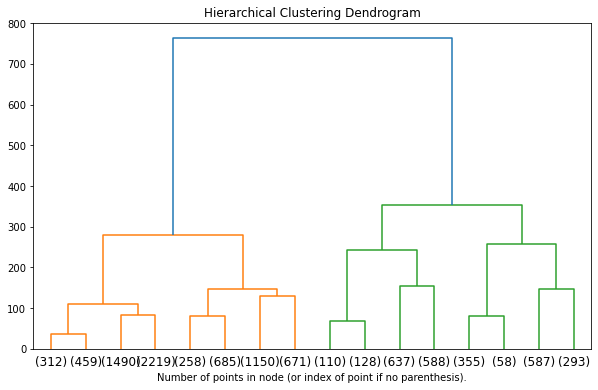

In [20]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.01, n_clusters=None)
X = df[:10000]
model = model.fit(X)
plt.figure(figsize=(10,6))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [22]:
idx = np.random.choice(np.arange(df.shape[0]), size=20000)
X = df[idx]
hierrachical_res = {}
print("Hierarchical Results : ")
start = time.perf_counter()
for i in np.arange(0.01, 5, 0.1):
    model = AgglomerativeClustering(distance_threshold=i, n_clusters=None)
    yhat = model.fit_predict(X)
    hierrachical_res[i] = metrics.calinski_harabasz_score(X, model.labels_)
    print(f"{i}: {hierrachical_res[i]}")
elapsed = (time.perf_counter() - start) / 60
print(f"Time taken: {elapsed} mins")

Hierarchical Results : 
0.01: 9040851.89758361
0.11: 69057.1281390791
0.21000000000000002: 25452.70463482195
0.31000000000000005: 15836.190449736916
0.41000000000000003: 11108.235367367426
0.51: 8478.9385908705
0.6100000000000001: 6901.911435021139
0.7100000000000001: 5757.955751741084
0.81: 4943.119570303223
0.91: 4383.799384605463
1.01: 3901.4074130646245
1.11: 3482.420355218433
1.2100000000000002: 3179.678719662744
1.31: 2923.4938654435527
1.4100000000000001: 2684.3112855687555
1.51: 2458.8934295573827
1.61: 2305.9826648370563
1.7100000000000002: 2168.31872518186
1.81: 2020.5658500420009
1.9100000000000001: 1902.7992548202249
2.01: 1798.322468120177
2.11: 1703.8451410220748
2.21: 1622.163647952109
2.31: 1547.400425773045
2.41: 1478.1914165819057
2.51: 1422.50661315206
2.61: 1374.7450789230113
2.71: 1324.4572073810386
2.81: 1287.1765718476724
2.91: 1254.7531508543293
3.01: 1217.9493692162534
3.11: 1187.7443280642558
3.21: 1162.5090441403895
3.31: 1138.0991235304214
3.41: 1114.3467839

In [20]:
silhouette['Hierarchical'] =  silhouette_score(X, model.labels_)
labels_17['Hierarchical'] = model.labels_

DBScan Clustering

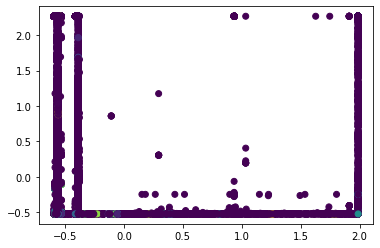

In [22]:
idx = np.random.choice(np.arange(df.shape[0]), size=100000)
X = df[idx]
model = DBSCAN(eps=0.02, min_samples=10, algorithm='ball_tree')
yhat = model.fit_predict(X)
plt.scatter(X[:,0],X[:,1] , c = yhat)

In [23]:
silhouette['DBScan'] =  silhouette_score(X, model.labels_)
labels_17['DBScan'] = model.labels_

In [15]:
idx = np.random.choice(np.arange(df.shape[0]), size=20000)
X = df[idx]
dbscan_res = {}
print("DBScan Results : ")
start = time.perf_counter()
for i in np.arange(0.01, 5, 0.1):
    model = DBSCAN(eps=i, min_samples=10, algorithm='ball_tree')
    yhat = model.fit_predict(X)
    dbscan_res[i] = metrics.calinski_harabasz_score(X, model.labels_)
    print(f"{i}: {dbscan_res[i]}")
elapsed = (time.perf_counter() - start) / 60
print(f"Time taken: {elapsed} mins")

DBScan Results : 
0.01: 16.799896853957573
0.11: 16.65914743661328
0.21000000000000002: 25.788273913326787
0.31000000000000005: 48.51436498629285
0.41000000000000003: 80.00271245204954
0.51: 115.32429632141643
0.6100000000000001: 145.0595998138913
0.7100000000000001: 166.43396498725295
0.81: 189.21912565906575
0.91: 207.39903492428542
1.01: 215.24869241991698
1.11: 228.00147934413917
1.2100000000000002: 234.72805788764225
1.31: 251.850649807046
1.4100000000000001: 268.9804890488444
1.51: 279.51867805305477
1.61: 297.19139166938123
1.7100000000000002: 298.617696337637
1.81: 311.68307412116553
1.9100000000000001: 346.18312194544745
2.01: 435.6083007500148
2.11: 490.2752926972681
2.21: 547.8586995717933
2.31: 501.75088592990215
2.41: 525.611571156086
2.51: 563.1621366384607
2.61: 617.2879948092477
2.71: 670.9531929636322
2.81: 729.6416907237345
2.91: 842.196251786953
3.01: 703.7458050280004
3.11: 768.3806722820499
3.21: 734.6969441100531
3.31: 782.9576453485206
3.41: 768.7408748769711
3.5

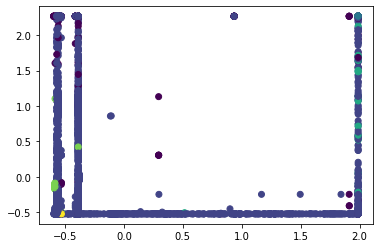

In [16]:
idx = np.random.choice(np.arange(df.shape[0]), size=20000)
X = df[idx]
model = DBSCAN(eps=4.91, min_samples=10, algorithm='ball_tree')
yhat = model.fit_predict(X)
plt.scatter(X[:,0],X[:,1] , c = yhat)

K-means Clustering

In [122]:
silhouette['KMeans'] =  silhouette_score(X, model.labels_)
labels_17['KMeans'] = model.labels_


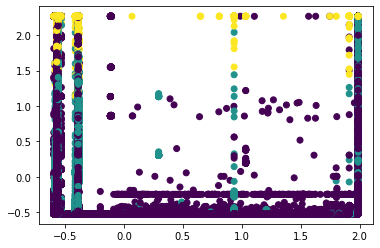

In [17]:
X = df
model = KMeans(n_clusters=3)
model.fit(X)
yhat = model.predict(X)
plt.scatter(X[:,0],X[:,1] , c = yhat)

In [19]:
kmeans_res = {}
print("KMeans Results : ")
start = time.perf_counter()
for i in range(2,11):
    model = KMeans(n_clusters=i)
    model.fit(X)
    yhat = model.predict(X)
    kmeans_res[i] = metrics.calinski_harabasz_score(X, model.labels_)
    print(f"{i}: {kmeans_res[i]}")
elapsed = (time.perf_counter() - start) / 60
print(f"Time taken: {elapsed} mins")

KMeans Results : 
2: 1536690.114629019
3: 1148633.6749950428
4: 1036390.6296932346
5: 984584.5335147219
6: 874291.2671646483
7: 789803.3727685511
8: 749817.7948472181
9: 694962.9621355269
10: 666457.3708461319
Time taken: 4.722789001666668 mins


Silhouette scores for the 3 clustering algorithms performed without PCA on the CIC-IDS 2017 dataset

In [65]:
print('Silhoutte scores of clustering algorithms:')
for i in silhouette:
    print(str(i) + " : " + str(silhouette[i]))

Silhoutte scores of clustering algorithms:
Hierarchical : 0.4403590140027256
DBScan : -0.05750747093125262
KMeans : 0.5507952889047317


Clustering on the CIC-IDS 2018 dataset

In [124]:
silhouette_18 = {}
labels_18 = {}

In [96]:
data_benign_18 = data_benign_18.values

Agglomerative Hierarchical Clustering (2018 dataset)

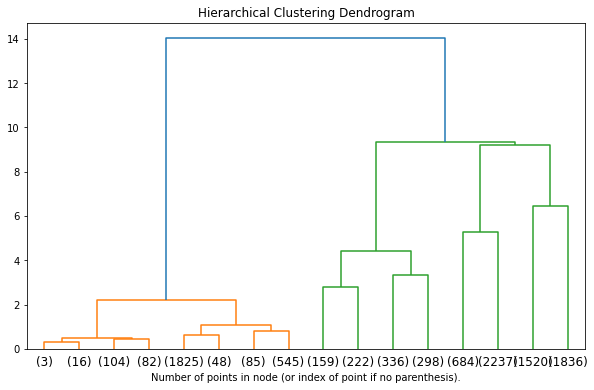

In [125]:
# Agglomerative Hierarchical
model = AgglomerativeClustering(distance_threshold=0.01, n_clusters=None)
X = data_benign_18[:10000]
model = model.fit(X)
plt.figure(figsize=(10,6))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
silhouette_18['Hierarchical'] =  silhouette_score(X, model.labels_)
labels_18['Hierarchical'] = model.labels_

DBScan Clustering (2018 dataset)

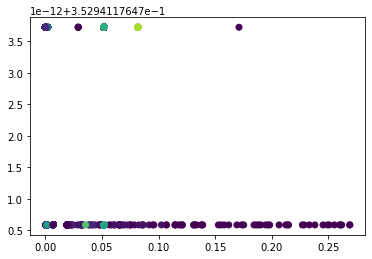

In [126]:
# DBScan
X = data_benign_18[:20000]
model = DBSCAN(eps=0.02, min_samples=10, algorithm='ball_tree')
yhat = model.fit_predict(X)
plt.scatter(X[:,0],X[:,1] , c = yhat)
silhouette_18['DBScan'] =  silhouette_score(X, model.labels_)
labels_18['DBScan'] = model.labels_

KMeans Clustering(2018 dataset)

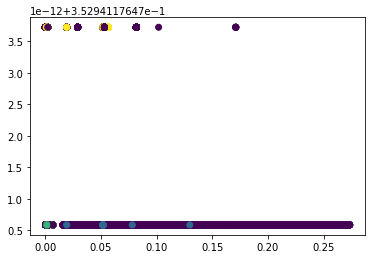

In [127]:
# KMeans
X = data_benign_18
model = KMeans(n_clusters=4)
model.fit(X)
yhat = model.predict(X)
plt.scatter(X[:,0],X[:,1] , c = yhat)

X = data_benign_18[:50000]
model = KMeans(n_clusters=4)
model.fit(X)
yhat = model.predict(X)
silhouette_18['KMeans'] =  silhouette_score(X, model.labels_)
labels_18['KMeans'] = model.labels_


Silhouette scores for the 3 clustering algorithms performed without PCA on the CIC-IDS 2018 dataset

In [112]:
print('Silhoutte scores of clustering algorithms on CIC-IDS-2018:')
for i in silhouette_18:
    print(str(i) + " : " + str(silhouette_18[i]))

Silhoutte scores of clustering algorithms on CIC-IDS-2018:
Hierarchical : 0.5391748771546402
DBScan : 0.5015643468805164
KMeans : 0.4663787566129123


# Clustering with PCA

Performing Principal Component Analysis(PCA) to reduce the dimensionality of the 2017 dataset

In [15]:
pca = PCA(n_components = 10)
principalComponents = pca.fit_transform(data_benign)

In [16]:
pca_df = pd.DataFrame(principalComponents).values
pca_df.shape

(2432027, 10)

In [13]:
silhouette_pca = {}
labels_17_pca = {}

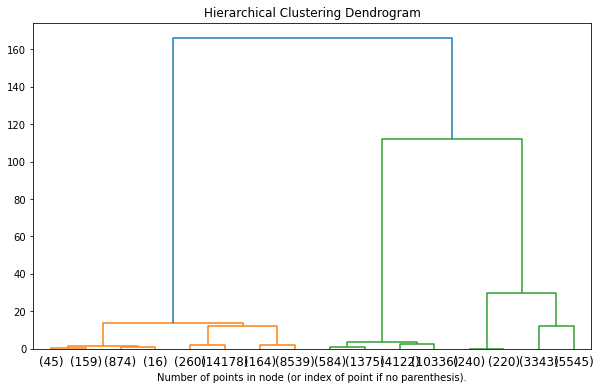

In [28]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.01, n_clusters=None)
X = pca_df[:50000]
model = model.fit(X)
plt.figure(figsize=(10,6))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [14]:
idx = np.random.choice(np.arange(pca_df.shape[0]), size=20000)
X = pca_df[idx]
hierrachical_res = {}
print("Hierarchical Results : ")
start = time.perf_counter()
for i in np.arange(0.01, 5, 0.1):
    model = AgglomerativeClustering(distance_threshold=i, n_clusters=None)
    yhat = model.fit(X)
    hierrachical_res[i] = metrics.calinski_harabasz_score(X, model.labels_)
    print(f"{i}: {hierrachical_res[i]}")
elapsed = (time.perf_counter() - start) / 60
print(f"Time taken: {elapsed} mins")

Hierarchical Results : 
0.01: 45604.42816218619
0.11: 17446.414924687804
0.21000000000000002: 17273.731648815174
0.31000000000000005: 17247.591139091448
0.41000000000000003: 17386.23928305346
0.51: 17470.935992573355
0.6100000000000001: 17070.10630852064
0.7100000000000001: 16729.23327327674
0.81: 16290.013089333037
0.91: 15959.96245729898
1.01: 15790.74213353413
1.11: 15547.899640702903
1.2100000000000002: 15471.292985403456
1.31: 15393.494013047819
1.4100000000000001: 15340.457017782886
1.51: 15294.357553355827
1.61: 15294.357553355827
1.7100000000000002: 15183.237497133025
1.81: 15183.237497133025
1.9100000000000001: 14984.211071421943
2.01: 14630.295093700863
2.11: 14518.902948000756
2.21: 14437.241059515123
2.31: 14401.062921801635
2.41: 14414.392555249791
2.51: 14473.85472110129
2.61: 14473.85472110129
2.71: 14473.85472110129
2.81: 14473.85472110129
2.91: 14461.612653723821
3.01: 14461.612653723821
3.11: 14639.83224963496
3.21: 14998.644982692818
3.31: 14998.644982692818
3.41: 15

In [29]:
silhouette_pca['Hierarchical PCA'] =  silhouette_score(X, model.labels_)
labels_17_pca['Hierarchical'] = model.labels_

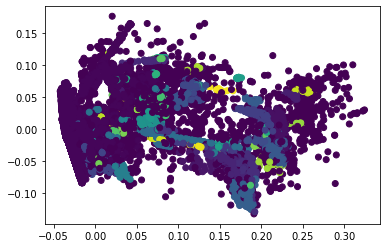

In [131]:
# DBSCAN
idx = np.random.choice(np.arange(pca_df.shape[0]), size=50000)
X = pca_df[idx]
model = DBSCAN(eps=0.02, min_samples=10, algorithm='ball_tree')
yhat = model.fit_predict(X)
plt.scatter(X[:,0],X[:,1] , c = yhat)

The error that is shown in this part of code execution is due the DBScan algorithm not able to generate more than one cluster for the data with the given hyperparameters

In [19]:
idx = np.random.choice(np.arange(pca_df.shape[0]), size=20000)
X = pca_df[idx]
dbscan_res = {}
print("DBScan Results : ")
start = time.perf_counter()
for i in np.arange(0.01, 1, 0.01):
    model = DBSCAN(eps=i, min_samples=10, algorithm='ball_tree')
    yhat = model.fit_predict(X)
    dbscan_res[i] = metrics.calinski_harabasz_score(X, model.labels_)
    print(f"{i}: {dbscan_res[i]}")
elapsed = (time.perf_counter() - start) / 60
print(f"Time taken: {elapsed} mins")

DBScan Results : 
0.01: 1372.6601830115615
0.02: 3262.6819927149218
0.03: 4639.647349831402
0.04: 4454.300516555449
0.05: 2487.3289507967775
0.060000000000000005: 2361.9164023878116
0.06999999999999999: 660.8700246846741
0.08: 192.91924615578304
0.09: 18.472553693332443
0.09999999999999999: 17.67207857340527
0.11: 11.313411407197245
0.12: 11.065392118001649
0.13: 3.2031516695718594


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [132]:
silhouette_pca['DBScan PCA'] =  silhouette_score(X, model.labels_)
labels_17_pca['DBScan'] = model.labels_

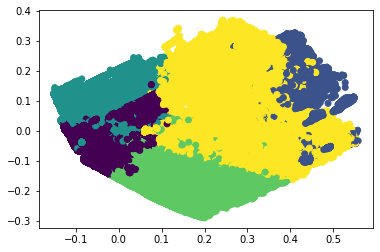

In [20]:
# KMeans
X = pca_df
kmeans_pca = KMeans(n_clusters=5, random_state=1)
kmeans_pca.fit(X)
yhat = kmeans_pca.predict(X)
plt.scatter(X[:,0],X[:,1] , c = yhat)
# for cluster_x, cluster_y in model.cluster_centers_:
#     plt.scatter(cluster_x, cluster_y, s=100, c='r', marker='x')



In [20]:
X = pca_df
kmeans_res = {}
print("KMeans Results : ")
start = time.perf_counter()
for i in range(2,11):
    model = KMeans(n_clusters=i)
    model.fit(X)
    yhat = model.predict(X)
    kmeans_res[i] = metrics.calinski_harabasz_score(X, model.labels_)
    print(f"{i}: {kmeans_res[i]}")
elapsed = (time.perf_counter() - start) / 60
print(f"Time taken: {elapsed} mins")

KMeans Results : 
2: 2069695.3315617256
3: 1854954.7083343714
4: 2100597.984291657
5: 2021134.0814754923
6: 2096221.756574448
7: 2041524.3779415435
8: 1923915.0367996003
9: 1845303.6075013317
10: 1783195.298367659
Time taken: 2.3548185033333313 mins


Silhouette scores for the 3 clustering algorithms with PCA on the CIC-IDS 2017 dataset

In [73]:
print('Silhoutte scores of clustering algorithms with PCA:')
for i in silhouette_pca:
    print(str(i) + " : " + str(silhouette_pca[i]))

Silhoutte scores of clustering algorithms with PCA:
Hierarchical PCA : 0.5631559640963095
DBScan PCA : 0.028641886892979754
KMeans PCA : 0.5503454011268331


Clustering on CIC-IDS 2018 with PCA

In [56]:
pca_18 = PCA(n_components = 10)
principalComponents = pca_18.fit_transform(data_benign_18)

In [57]:
pca_df_18 = pd.DataFrame(principalComponents).values
pca_df_18.shape

(286191, 2)

In [135]:
silhouette_pca_18 = {}
labels_18_pca = {}

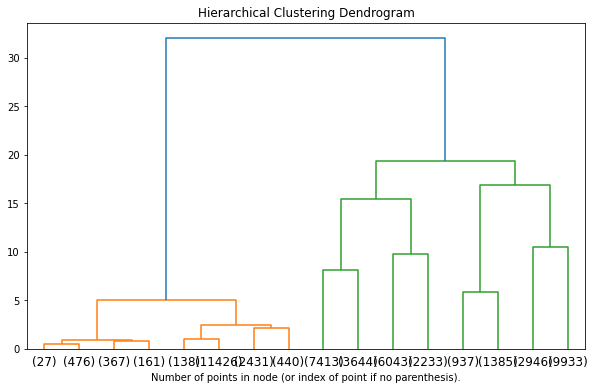

In [145]:
# Agglomerative Hierarchical
model = AgglomerativeClustering(distance_threshold=0.01, n_clusters=None)
X = pca_df_18[:50000]
model = model.fit(X)
plt.figure(figsize=(10,6))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
silhouette_pca_18['Hierarchical'] =  silhouette_score(X, model.labels_)
labels_18_pca['Hierarchical'] = model.labels_

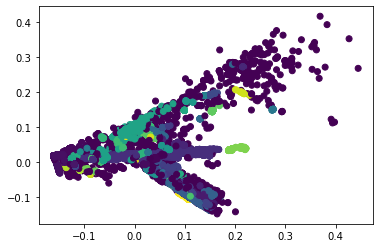

In [142]:
# DBScan
X = pca_df_18[:50000]
model = DBSCAN(eps=0.02, min_samples=10, algorithm='ball_tree')
yhat = model.fit_predict(X)
plt.scatter(X[:,0],X[:,1] , c = yhat)
silhouette_pca_18['DBScan'] =  silhouette_score(X, model.labels_)
labels_18_pca['DBScan'] = model.labels_

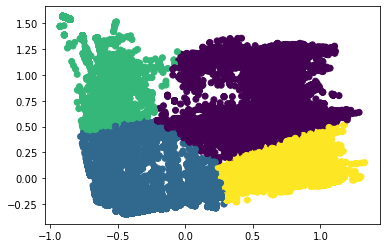

In [49]:
# KMeans
X = pca_df_18
model = KMeans(n_clusters=4)
model.fit(X)
yhat = model.predict(X)
plt.scatter(X[:,0],X[:,1] , c = yhat)

X = pca_df_18[:50000]
model = KMeans(n_clusters=4)
model.fit(X)
yhat = model.predict(X)
silhouette_pca_18['KMeans'] =  silhouette_score(X, model.labels_)
labels_18_pca['KMeans'] = model.labels_
old_data = model.labels_
old_centroids = model.cluster_centers_

Silhouette scores for the 3 clustering algorithms performed with PCA on the CIC-IDS 2018 dataset

In [113]:
print('Silhoutte scores of clustering algorithms with PCA on CIC-IDS 2018:')
for i in silhouette_pca_18:
    print(str(i) + " : " + str(silhouette_pca_18[i]))

Silhoutte scores of clustering algorithms with PCA on CIC-IDS 2018:
Hierarchical : 0.6062932602936113
DBScan : 0.39725952870411785
KMeans : 0.4929779179817051


# Classification

Importing Scipy library component pdist, it is used to calculate the pairwise distances of a give set of points

In [4]:
from scipy.spatial.distance import pdist

Function to train the model

In [39]:
def train(path, folder = False):
    start = time.perf_counter()
    if folder:
        files = glob.glob(path + '/*.csv')
        csvList = [pd.read_csv(f,encoding='cp1252') for f in files]
        data = pd.concat(csvList,ignore_index=True)
        print('Loaded ' + str(len(csvList)) + ' files')
    else:
        chunk = pd.read_csv(path,encoding='cp1252', chunksize=100000)
        data = pd.concat(chunk,ignore_index=True)
        print('Loaded ' + str(path) + ' file')
    
    data = data.rename(columns=lambda x: x.strip())
  
    # Convert Label column names to lower case
    data['Label'] = data['Label'].str.lower()
    labels = list(data['Label'].unique())
    print('Labels: ' + str(labels))

    df_benign = data[data['Label'] == 'benign']
    # df_benign.drop(['Label'], axis=1, inplace=True)
    df_benign.drop(['Label' ,'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp' , 'Protocol'], axis=1, inplace=True)
    df_benign = preprocess(df_benign)
    
    print('\n\nStarting training...')
   
    
    pca = PCA(n_components = 10)
    principalComponents = pca.fit_transform(df_benign)
    X = pd.DataFrame(principalComponents).values
    model = KMeans(n_clusters=4)
    model.fit_predict(X)
    benign_centroids = model.cluster_centers_
    d = pdist(np.array(benign_centroids))
    
    labels.remove('benign')
    dist = {}
    
    for i in labels:
        print(i)
        df = data[data['Label'] == i]
        df.drop(['Label' ,'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp' , 'Protocol'], axis=1, inplace=True)
        df = preprocess(df)
        pca = PCA(n_components = 2)
        principalComponents = pca.fit_transform(df)
        X = pd.DataFrame(principalComponents).values
        model = KMeans(n_clusters=4)
        model.fit_predict(X)
        centroids = model.cluster_centers_
        
        d2 = pdist(np.array(centroids))
        sum = 0
        for j in range(0,6):
            s = 0
            for k in range(0,6):
                s += abs(d2[j] - d[k])
            sum += s / 6
        avg_score  = sum / 6
        dist[i] = avg_score
    
    for j in dist:
        print(j + ' : ' + str(dist[j]))    
        
    avg = float(np.sum(list(dist.values())) / len(labels))
    end = time.perf_counter()
    print('Training time: ' + str(end - start))
    print('Average distance between benign and malware clusters: ' + str(avg))
    
    return avg

Function to test the model

In [6]:
def test(data, threshold):
    data = preprocess(data)
    
    pca = PCA(n_components = 2)
    principalComponents = pca.fit_transform(data)
    X = pd.DataFrame(principalComponents).values
    model = KMeans(n_clusters=4)
    model.fit_predict(X)
    benign_centroids = model.cluster_centers_
    d = pdist(np.array(benign_centroids))
    d = np.sum(d) / len(d)
    print('Distance: ' + str(d))
    
    if d >= threshold:
        print('Malicious')
        return 0
    else:
        print('Benign')
        return 1

Training on CIC-IDS 2017 dataset

In [7]:
thresh = train('D:\RIT\Courses\Spring2022\ML4Cyber\Datasets\CIC-IDS2017\MachineLearningCVE', True)

Loaded 8 files
Labels: ['benign', 'ddos', 'portscan', 'bot', 'infiltration', 'web attack ï¿½ brute force', 'web attack ï¿½ xss', 'web attack ï¿½ sql injection', 'ftp-patator', 'ssh-patator', 'dos slowloris', 'dos slowhttptest', 'dos hulk', 'dos goldeneye', 'heartbleed']


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Columns with only 1 unique values : 8
Before replacing, nan = 3554
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (2273097, 68)


Starting training...
ddos
Columns with only 1 unique values : 17


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Before replacing, nan = 4
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (128027, 60)
portscan
Columns with only 1 unique values : 16


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Before replacing, nan = 252
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (158930, 61)
bot
Columns with only 1 unique values : 16
Before replacing, nan = 20
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (1966, 61)
infiltration


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Columns with only 1 unique values : 15
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (36, 64)
web attack ï¿½ brute force


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Columns with only 1 unique values : 29
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (1507, 50)
web attack ï¿½ xss


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Columns with only 1 unique values : 29
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (652, 50)
web attack ï¿½ sql injection


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Columns with only 1 unique values : 29
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (21, 50)
ftp-patator


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Columns with only 1 unique values : 25
Before replacing, nan = 6
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (7938, 52)
ssh-patator


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Columns with only 1 unique values : 25
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (5897, 54)
dos slowloris


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Columns with only 1 unique values : 15
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (5796, 64)
dos slowhttptest


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Columns with only 1 unique values : 15
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (5499, 64)
dos hulk


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Columns with only 1 unique values : 16


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Before replacing, nan = 1898
After replacing, nan = 0
Columns with only 1 unique values : 1
Final shape of DF = (231073, 62)
dos goldeneye
Columns with only 1 unique values : 19
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (10293, 60)


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


heartbleed
Columns with only 1 unique values : 26
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (11, 53)
ddos : 2.4291991583871506
portscan : 0.23063805032132642
bot : 1.9457250057312019
infiltration : 2.4045814825381835
web attack ï¿½ brute force : 3.2399829869784926
web attack ï¿½ xss : 3.2929013816348984
web attack ï¿½ sql injection : 3.4784227099751397
ftp-patator : 2.60151478674926
ssh-patator : 2.410036506509274
dos slowloris : 2.9403489676234664
dos slowhttptest : 2.513653494579287
dos hulk : 2.1158881354841452
dos goldeneye : 2.4762992489241595
heartbleed : 2.805716633554065
Training time: 99.9217957
Average distance between benign and malware clusters: 2.4917791820707182


C:\Users\jazee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
print(thresh)

2.4917791820707182


Testing on CIC-IDS 2018 dataset

In [18]:
pd.options.mode.chained_assignment = None

In [20]:
path = 'D:\RIT\Courses\Spring2022\ML4Cyber\Datasets\CICIDS2018'
files = glob.glob(path + '/*.csv')
score = 0
count = 0
print('Starting testing...')
for f in files:

    data = pd.read_csv(f, encoding='cp1252')
    data = data.rename(columns=lambda x: x.strip())

    data['Label'] = data['Label'].str.lower()
    print(data.select_dtypes(include=['object']).columns.tolist())
    labels = list(data['Label'].unique())
    print('\nLabels: ' + str(labels))
    for l in labels:
        count += 1
        df = data[data['Label'] == l]
        df.drop(['Label', 'Timestamp', 'Protocol' , 'Dst Port'], axis=1, inplace=True)
        df = df.astype(float)
        predicted = test(df, thresh)
        print('Actual: ' + l + '\tPredicted:' +
              ('Malicious' if predicted == 0 else 'Benign'))
        if l == 'benign' and predicted == 1:
            score += 1
        elif l != 'benign' and predicted == 0:
            score += 1

    del df
    del data
print('Score: ' + str(score) + '/' + str(count))
print('Accuracy: ' + str(score / count))


Starting testing...
['Timestamp', 'Label']

Labels: ['benign', 'bot']
Columns with only 1 unique values : 10
Before replacing, nan = 8100
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (762384, 64)
Distance: 1.2995836182735878
Benign
Actual: benign	Predicted:Benign
Columns with only 1 unique values : 13
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (286191, 63)
Distance: 1.1470684165570502
Benign
Actual: bot	Predicted:Benign
['Timestamp', 'Label']

Labels: ['benign', 'brute force -web', 'brute force -xss', 'sql injection']
Columns with only 1 unique values : 10
Before replacing, nan = 11416
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (1048009, 64)
Distance: 1.206740764681413
Benign
Actual: benign	Predicted:Benign
Columns with only 1 unique values : 13
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape

In [22]:
path = 'D:\RIT\Courses\Spring2022\ML4Cyber\Datasets\CIC-IDS2017\MachineLearningCVE'
files = glob.glob(path + '/*.csv')
score = 0
count = 0
print('Starting testing...')
for f in files:

    data = pd.read_csv(f, encoding='cp1252')
    data = data.rename(columns=lambda x: x.strip())

    data['Label'] = data['Label'].str.lower()
    print(data.select_dtypes(include=['object']).columns.tolist())
    labels = list(data['Label'].unique())
    print('\nLabels: ' + str(labels))
    for l in labels:
        count += 1
        df = data[data['Label'] == l]
        df.drop(['Label'], axis=1, inplace=True)
        df = df.astype(float)
        predicted = test(df, thresh)
        print('Actual: ' + l + '\tPredicted:' +
              ('Malicious' if predicted == 0 else 'Benign'))
        if l == 'benign' and predicted == 1:
            score += 1
        elif l != 'benign' and predicted == 0:
            score += 1

    del df
    del data
print('Score: ' + str(score) + '/' + str(count))
print('Accuracy: ' + str(score / count))


Starting testing...
['Label']

Labels: ['benign', 'ddos']
Columns with only 1 unique values : 10
Before replacing, nan = 64
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (97718, 66)
Distance: 1.4272381176577351
Benign
Actual: benign	Predicted:Benign
Columns with only 1 unique values : 16
Before replacing, nan = 4
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (128027, 60)
Distance: 2.655584083423228
Malicious
Actual: ddos	Predicted:Malicious
['Label']

Labels: ['benign', 'portscan']
Columns with only 1 unique values : 10
Before replacing, nan = 490
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (127537, 66)
Distance: 0.4839135258819443
Benign
Actual: benign	Predicted:Benign
Columns with only 1 unique values : 15
Before replacing, nan = 252
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (158930, 61)
Distance: 0.4570229753574058
Benign
Actual: p

Testing on USB-IDS dataset

In [31]:
path = 'D:\RIT\Courses\Spring2022\ML4Cyber\Datasets\\USBIDS'
files = glob.glob(path + '/*.csv')
score = 0
count = 0
print('Starting testing...')
for f in files:
    data = pd.read_csv(f, encoding='cp1252')
    data = data.rename(columns=lambda x: x.strip())
    
    data['Label'] = data['Label'].str.lower()
    print(data.select_dtypes(include=['object']).columns.tolist())
    labels = list(data['Label'].unique())
    print('\nLabels: ' + str(labels))
    for l in labels:
        count += 1
        df = data[data['Label'] == l]
        df.drop(['Label' ,'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp' , 'Protocol'], axis=1, inplace=True)
        df = df.astype(float)
        predicted = test(df, thresh)
        print('Actual: ' + l + '\tPredicted:' +
              ('Malicious' if predicted == 0 else 'Benign'))
        if l == 'benign' and predicted == 1:
            score += 1
        elif l != 'benign' and predicted == 0:
            score += 1

    del df
    del data
print('Score: ' + str(score) + '/' + str(count))
print('Accuracy: ' + str(score / count))


Starting testing...
['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label']

Labels: ['benign']
Columns with only 1 unique values : 5
Before replacing, nan = 10542
After replacing, nan = 0
Columns with only 1 unique values : 2
Final shape of DF = (305921, 69)
Distance: 1.4158676277747786
Benign
Actual: benign	Predicted:Benign
['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label']

Labels: ['tcpflood-evasive', 'hulk-nodefense', 'benign', 'hulk-security2', 'hulk-reqtimeout', 'hulk-evasive', 'tcpflood-reqtimeout', 'slowhttptest-evasive', 'tcpflood-nodefense', 'slowhttptest-security2', 'tcpflood-security2', 'slowhttptest-reqtimeout', 'slowhttptest-nodefense', 'slowloris-reqtimeout', 'slowloris-security2', 'slowloris-nodefense', 'slowloris-evasive']
Columns with only 1 unique values : 23
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (45390, 53)
Distance: 2.3269527005453106
Benign
Actual: tcpflood-evasive	Predicted:Benign
Columns wi

Training and Testing on USB-IDS dataset 

In [40]:
thresh2 = train('D:\RIT\Courses\Spring2022\ML4Cyber\Datasets\\USBIDS\\USB-IDS-1-TRAIN.csv', False)

Loaded D:\RIT\Courses\Spring2022\ML4Cyber\Datasets\USBIDS\USB-IDS-1-TRAIN.csv file
Labels: ['tcpflood-evasive', 'hulk-nodefense', 'benign', 'hulk-security2', 'hulk-reqtimeout', 'hulk-evasive', 'tcpflood-reqtimeout', 'slowhttptest-evasive', 'tcpflood-nodefense', 'slowhttptest-security2', 'tcpflood-security2', 'slowhttptest-reqtimeout', 'slowhttptest-nodefense', 'slowloris-reqtimeout', 'slowloris-security2', 'slowloris-nodefense', 'slowloris-evasive']
Columns with only 1 unique values : 6
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (213311, 70)


Starting training...
tcpflood-evasive
Columns with only 1 unique values : 23
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (211801, 53)
hulk-nodefense
Columns with only 1 unique values : 14
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (595790, 62)
hulk-secu

In [44]:
data = pd.read_csv('D:\RIT\Courses\Spring2022\ML4Cyber\Datasets\\USBIDS\\USB-IDS-1-TEST.csv', encoding='cp1252')
data = data.rename(columns=lambda x: x.strip())
data['Label'] = data['Label'].str.lower()
labels = list(data['Label'].unique())

count = 0
score = 0
for l in labels:
    count += 1
    df = data[data['Label'] == l]
    df.drop(['Label' ,'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp' , 'Protocol'], axis=1, inplace=True)
    df = df.astype(float)
    predicted = test(df, thresh2)
    print('Actual: ' + l + '\tPredicted:' +
              ('Malicious' if predicted == 0 else 'Benign'))
    if l == 'benign' and predicted == 1:
        score += 1
    elif l != 'benign' and predicted == 0:
        score += 1
print('Score: ' + str(score) + '/' + str(count))
print('Accuracy: ' + str(score / count))

Columns with only 1 unique values : 23
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (45390, 53)
Distance: 2.326972532812515
Malicious
Actual: tcpflood-evasive	Predicted:Malicious
Columns with only 1 unique values : 16
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (127671, 60)
Distance: 1.7303218982381565
Malicious
Actual: hulk-nodefense	Predicted:Malicious
Columns with only 1 unique values : 6
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (45708, 70)
Distance: 1.6834779586028052
Malicious
Actual: benign	Predicted:Malicious
Columns with only 1 unique values : 10
Before replacing, nan = 0
After replacing, nan = 0
Columns with only 1 unique values : 0
Final shape of DF = (121956, 66)
Distance: 1.4120822306154786
Benign
Actual: hulk-security2	Predicted:Benign
Columns with only 1 unique values : 15
Befor

----------------------------------